In [1]:
# Downgrade numpy and to force compatibility
!pip uninstall -y numpy
!pip install numpy==1.24.4

Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
schnetpack 2.1.1 requires numpy>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
trees

In [36]:
# Install
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install ase rdkit-pypi
!pip install py3Dmol
#install schnetpack without upgrading numpy cause it will re break everything
!pip install 'schnetpack<=0.4.0' --no-deps


Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


In [43]:
import torch
from torch_geometric.nn.models import SchNet
from torch_geometric.data import Data
from ase.io import read
from rdkit.Chem import AllChem
import numpy as np
from ase import Atoms
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from torch_geometric.datasets import QM9
from torch import Tensor
from torch_geometric.typing import OptTensor
from scipy.spatial.distance import euclidean

In [3]:
def ase_to_pyg(ase_atoms, z_table=None, cutoff=5.0):
    pos = torch.tensor(ase_atoms.get_positions(), dtype=torch.float)
    atomic_numbers = torch.tensor(ase_atoms.get_atomic_numbers(), dtype=torch.long)
    edge_index = radius_graph(pos, r=cutoff)

    data = Data(z=atomic_numbers, pos=pos, edge_index=edge_index)
    return data

In [4]:
#upload sample pdb
from google.colab import files
uploaded = files.upload()
pdb_path = next(iter(uploaded))
atoms = read(pdb_path)


Saving test_molecule.pdb to test_molecule (1).pdb


In [34]:
def show_molecule(atoms: Atoms, label_atoms: bool = True, width=400, height=400):
    xyz_str = f"{len(atoms)}\n\n"
    for i, (sym, pos) in enumerate(zip(atoms.get_chemical_symbols(), atoms.get_positions())):
        xyz_str += f"{sym} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n"

    view = py3Dmol.view(width=width, height=height)
    view.addModel(xyz_str, 'xyz')
    view.setStyle({'stick': {}, 'sphere': {'scale': 0.25}})
    view.zoomTo()

    if label_atoms:
        for i, pos in enumerate(atoms.get_positions()):
            view.addLabel(str(i), {'position': {'x': float(pos[0]),
                                                'y': float(pos[1]),
                                                'z': float(pos[2])},
                                   'backgroundColor': 'black',
                                   'fontColor': 'white',
                                   'showBackground': True,
                                   'fontSize': 12})

    return view.show()


This viewer package doesnt show it but atoms 8 and 11 are double bonded as you can see by the number of hydrogens and the bond is a little shorter

In [38]:
show_molecule(atoms)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
data = ase_to_pyg(atoms)

In [11]:
data = ase_to_pyg(atoms)
root = './qm9_pretrained'
dataset_raw = QM9(root)
target = 7

In [40]:
class SchNetWithFeatures(SchNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward_features(self, z: Tensor, pos: Tensor,
                batch: OptTensor = None) -> Tensor:
        """I just copied and pasted the forward pass from  the following link and then truncated it after the interaction blocks (lin1 and lin2 are condensing the feature vectors down to a single target val)
        https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/schnet.html#SchNet.from_qm9_pretrained
        """
        batch = torch.zeros_like(z) if batch is None else batch

        h = self.embedding(z)
        edge_index, edge_weight = self.interaction_graph(pos, batch)
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)

        return h


In [41]:
# Load pretrained model
model_base, dataset = SchNet.from_qm9_pretrained(root, dataset_raw, target)

# Create subclassed model with same parameters
model = SchNetWithFeatures(
    hidden_channels=model_base.hidden_channels,
    num_filters=model_base.num_filters,
    num_interactions=model_base.num_interactions,
    num_gaussians=model_base.num_gaussians,
    cutoff=model_base.cutoff,
    max_num_neighbors=32,
)

#wont run without this idk why dont touch
model.atomref = model_base.atomref
model.register_buffer('initial_atomref', model_base.initial_atomref)

# Load model
model.load_state_dict(model_base.state_dict())
model.eval()

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


SchNetWithFeatures(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)

In [18]:
with torch.no_grad():
    features = model.forward_features(data.z, data.pos, batch=batch)

In [21]:
print(f"This pretrained model has {features[0].shape} features")
print("features of atom 0")
print(features[0])

This pretrained model has torch.Size([128]) features
features of atom 0
tensor([-1.4772,  0.6921,  0.1478, -2.7280, -0.9597, -1.5190, -1.2221, -1.5278,
        -0.6419,  0.5169,  2.2019, -1.2506,  2.1048,  0.9289,  1.0646, -0.3342,
        -1.0704, -0.5291,  0.8239, -0.5796,  0.9894, -1.8065,  1.5462, -0.2875,
         0.0501,  0.0345, -0.2378, -2.2475,  0.7287, -0.1568, -1.4390, -0.1304,
        -0.4022, -0.5266, -0.0154, -2.0444, -0.4692,  0.3782, -1.0176,  0.6460,
         1.1441,  0.5233, -1.4266, -0.3518, -1.5576, -0.0204, -0.6198, -0.2199,
         2.0713,  0.7620,  0.4476,  1.2141,  1.6090,  1.0299,  2.0546,  3.4475,
        -0.0933,  0.1194,  2.0774, -0.0508,  0.3562,  0.7878,  1.8549,  0.1068,
         0.4661, -0.3322,  0.9424,  1.4046, -2.8743, -0.2433, -1.5962,  0.1778,
        -0.9595, -0.5064,  0.5415,  0.7368, -0.0062,  1.5379, -1.6072, -0.8599,
         0.1886, -0.0775, -3.4082,  1.3072,  1.3295,  0.1738, -0.2924, -0.0591,
         0.2019, -2.4461,  1.2653, -0.3309, -1.2

In [44]:
def distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return euclidean(v1.flatten(), v2.flatten())

In [46]:
distances = np.zeros((len(features), len(features)))
for i in range(len(features)):
    for j in range(len(features)):
        distances[i, j] = distance(features[i], features[j])

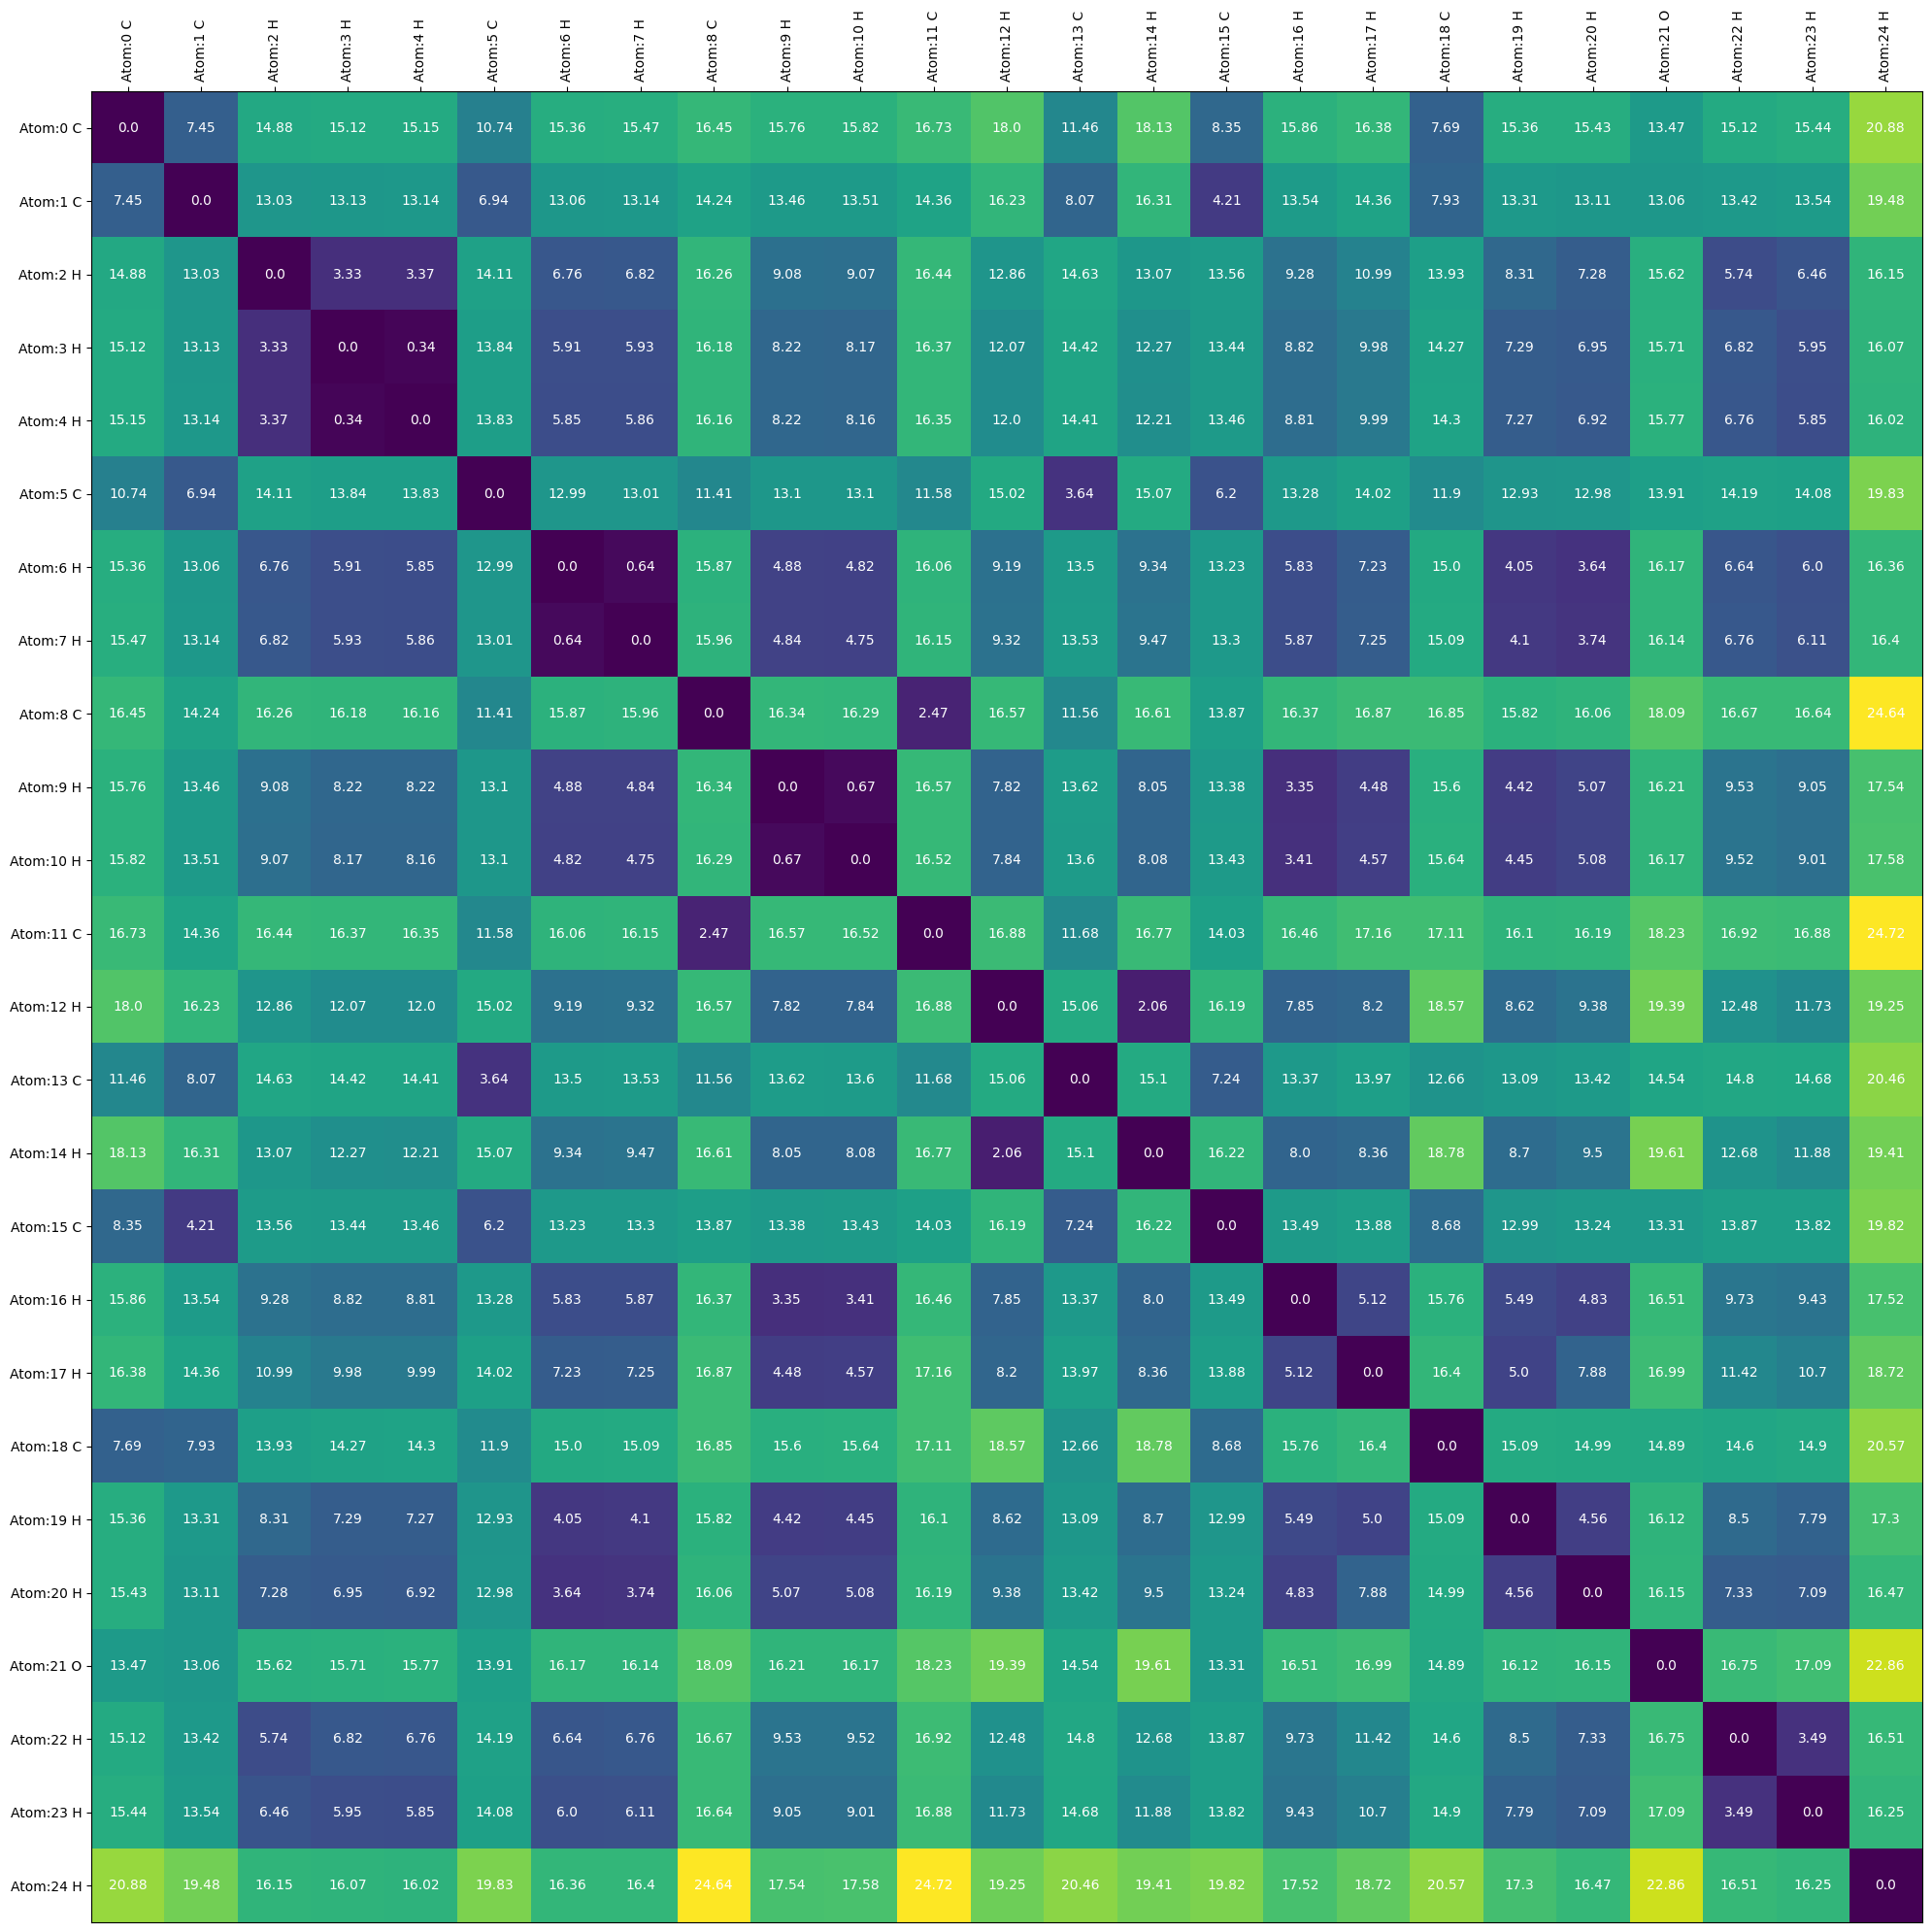

In [54]:
import matplotlib.pyplot as plt
l = []
for i,val in enumerate(atoms.get_chemical_symbols()):
  l.append(f"Atom:{i} {val}")
fig,ax = plt.subplots(figsize=(20,20))
im = ax.imshow(distances)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(len(l)),labels=l,rotation=90)
ax.set_yticks(range(len(l)),labels=l)
for i in range(len(l)):
  for j in range(len(l)):
    text = ax.text(j, i, round(distances[i, j], 2),
                   ha="center", va="center", color="w")
fig.tight_layout()
plt.show()